## Mod vae_tst1 to work with different inputs and outputs
Basically change the cost function to compute loss between X and Y images instead of itself

## Test effect of latent dims on MNIST data

In [1]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Lambda
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt
import tensorflow as tf
import keras


GPU=True
CPU=False
num_cores = 8

if GPU:
    num_GPU = 1
    num_CPU = 4
if CPU:
    num_CPU = num_cores
    num_GPU = 0

config = tf.ConfigProto(intra_op_parallelism_threads=num_cores,\
        inter_op_parallelism_threads=num_cores, allow_soft_placement=True,\
        device_count = {'CPU' : num_CPU, 'GPU' : num_GPU},\
#        gpu_options=tf.GPUOptions(per_process_gpu_memory_fraction=0.5))
                       )
config.gpu_options.allow_growth = True

session = tf.Session(config=config)
K.set_session(session)


/Users/mathew/anaconda/envs/egpu/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
%matplotlib inline

#Needs to follow inline magick command
import matplotlib
plt.style.use('seaborn-white')
matplotlib.rc('font',family='Times New Roman')
matplotlib.rcParams['font.size'] = 32
plt.rcParams['image.cmap'] = 'viridis'

In [3]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))  # adapt this if using `channels_first` image data format
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format

In [108]:
K.clear_session()
latent_dim=16 #Dimensionality of latent space
batch_size=128
kl_weight= -500e-4 #How much to weight the adherence to the distribution

#Encoder network
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
# at this point the representation is (4, 4, 8) i.e. 128-dimensional
shape_b4_flatten=K.int_shape(x)
x=Flatten()(x)


#Map to latent space following a known distribution
z_mean=Dense(latent_dim)(x)
z_log_var=Dense(latent_dim)(x)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_var]) #keras.layers. Lambda


#Decoder starts here
#Unlike autoencoder, keep this separate so can work with the halves!
print (shape_b4_flatten[1:],np.prod(shape_b4_flatten[1:]))
print (K.int_shape(z)[0:],K.shape(z_mean)[0])

decoder_input=Input(K.int_shape(z)[1:])
x = Dense(np.prod(shape_b4_flatten[1:]), activation='relu')(decoder_input) #prod of tuple mults the dims
x = Reshape(shape_b4_flatten[1:])(x)
print(K.int_shape(x))
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
print(K.int_shape(x))
decoder=Model(decoder_input, x)


#Apply decoder to the distribution
z_decoded=decoder(z)
print(K.int_shape(z_decoded))


#Custom loss function
#class own_var_lyr(keras.layers.Layer):
def vae_loss(y, z_decoded):
        y = K.flatten(y)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(y, z_decoded)
        
        #KL divergence, see : 
        #http://louistiao.me/posts/implementing-variational-autoencoders-in-keras-beyond-the-quickstart-tutorial/
        kl_loss = kl_weight * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss+kl_loss)
        # Loss function represents both accuracy of reconstructed image as well as a regularization loss 
        # that helps learn well-formed spaces and reduce overfitting


# VAE model statement
vae = Model(input_img, z_decoded)
vae.compile(optimizer='rmsprop', loss=vae_loss)
vae.summary()

((4, 4, 8), 128)
((None, 16), <tf.Tensor 'strided_slice:0' shape=() dtype=int32>)
(None, 4, 4, 8)
(None, 28, 28, 1)
(None, 28, 28, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 8)    1160        max_pooli

In [109]:
#dirpath='/tmp/autoencoder'
epochs=50

#if tf.gfile.Exists(dirpath):
#   tf.gfile.DeleteRecursively(dirpath) 

#from keras.callbacks import TensorBoard

history=vae.fit(x=x_train, y=x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=0.1)


Train on 54000 samples, validate on 6000 samples
Epoch 1/50
54000/54000 [==============================] - 5s 86us/step - loss: 0.2434 - val_loss: 0.1934
Epoch 2/50
54000/54000 [==============================] - 4s 82us/step - loss: 0.1837 - val_loss: 0.1733
Epoch 3/50
54000/54000 [==============================] - 4s 78us/step - loss: 0.1683 - val_loss: 0.1618
Epoch 4/50
54000/54000 [==============================] - 4s 78us/step - loss: 0.1599 - val_loss: 0.1558
Epoch 5/50
54000/54000 [==============================] - 4s 77us/step - loss: 0.1543 - val_loss: 0.1548
Epoch 6/50
54000/54000 [==============================] - 4s 77us/step - loss: 0.1503 - val_loss: 0.1508
Epoch 7/50
54000/54000 [==============================] - 4s 77us/step - loss: 0.1472 - val_loss: 0.1463
Epoch 8/50
54000/54000 [==============================] - 4s 77us/step - loss: 0.1445 - val_loss: 0.1496
Epoch 9/50
54000/54000 [==============================] - 4s 77us/step - loss: 0.1424 - val_loss: 0.1439
Epoch 

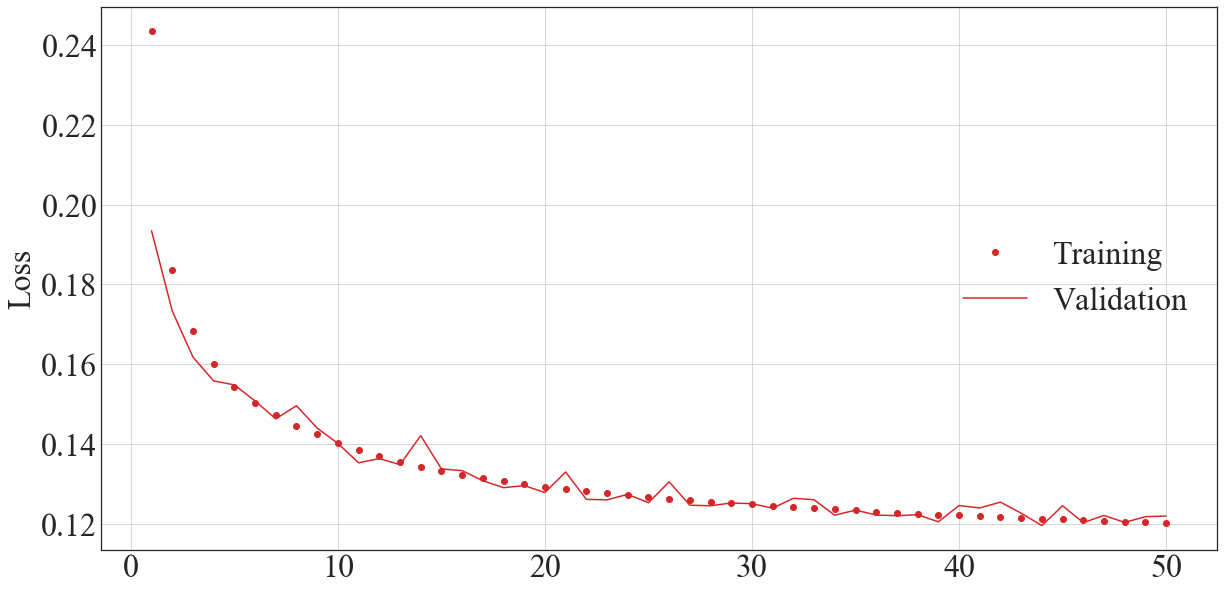

In [110]:

hist=history
epochs=np.asarray(history.epoch)+1


f, axarr = plt.subplots(1, sharex=True, figsize=(20, 10))

axarr.set(ylabel='Loss')
axarr.plot(epochs,hist.history['loss'], 'C3o', label='Training')
axarr.plot(epochs,hist.history['val_loss'], 'C3-', label='Validation')
axarr.grid()
axarr.legend(loc='center right', bbox_to_anchor=(1.0, 0.5))


#axarr[1].plot(epochs,hist.history['acc'], 'C0o', label='Training')
#axarr[1].plot(epochs,hist.history['val_acc'], 'C0-', label='Validation')
#plt.legend(loc='center right', bbox_to_anchor=(1.0, 0.5))
#plt.xlabel('Epochs')
#plt.ylabel('Accuracy')
#plt.tight_layout()
#plt.grid()
#plt.tick_params(which='both', width=2)
#plt.tick_params(which='major', length=7)
#plt.tick_params(which='minor', length=5)

10000/10000 [==============================] - 1s 59us/step


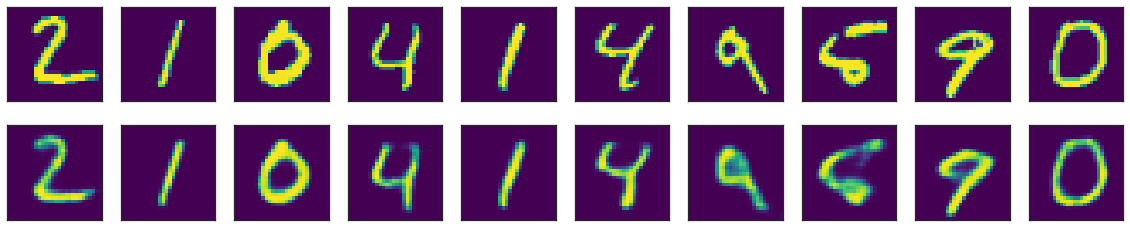

In [111]:
decoded_imgs = vae.predict(x_test, verbose=True)

n = 10
plt.figure(figsize=(20, 4))
for i in range(1,n+1):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(28, 28))
#    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
#    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.savefig('%d_dim_space.png' %latent_dim)
plt.show()
#plt.savefig('%d_dim_space.png' %latent_dim)

In [112]:
#i=100
#np.max(x_test[i]-vae.predict(x_test[i].reshape(1,28,28,1)))
mse=((x_test-decoded_imgs)**2).mean(axis=None)
print (round(mse,5))

0.01566


In [9]:
from scipy.stats import norm
# Display a 2D manifold of the digits--will only work if latent_dim is 2
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

# decode for each square in the grid
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='viridis')
plt.colorbar()
plt.show() 

ValueError: Error when checking : expected input_2 to have shape (None, 64) but got array with shape (128, 2)